Initial dataset shape: (9999, 9)
Initial missing values:
 movies         0
year         644
genre         80
rating      1820
one-line       0
stars          0
votes       1820
runtime     2958
gross       9539
dtype: int64
Flagged 459 outliers in 'rating'
Flagged 167 outliers in 'runtime'


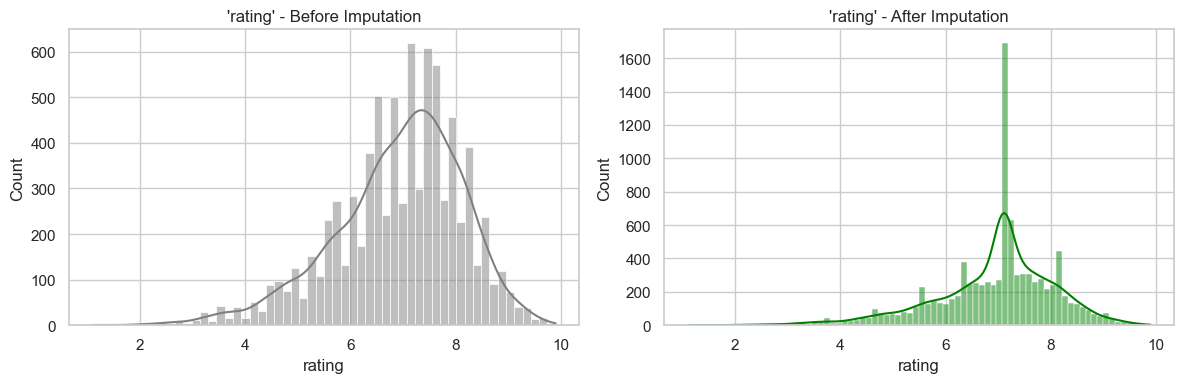

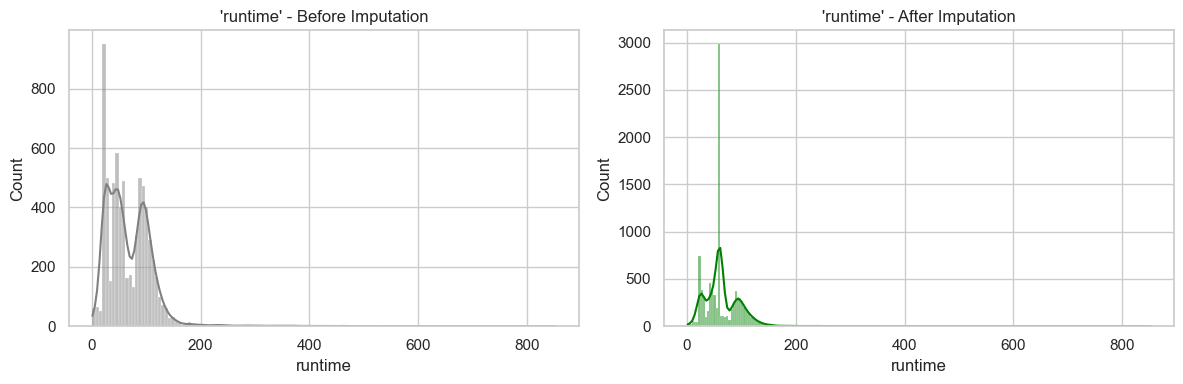

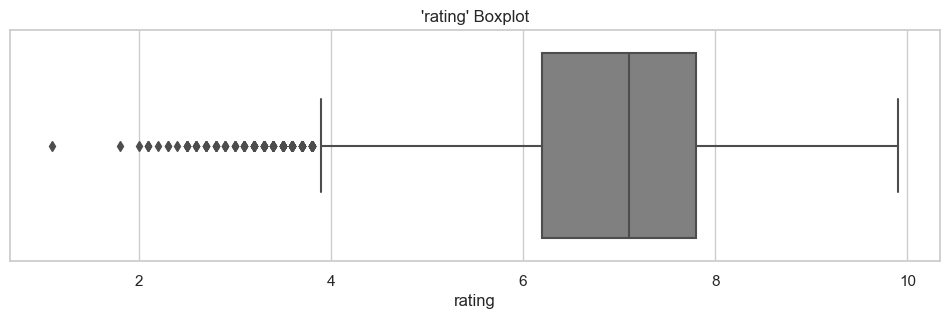

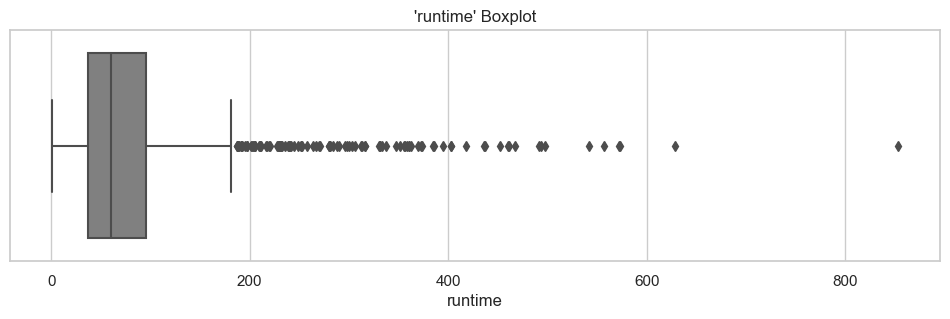

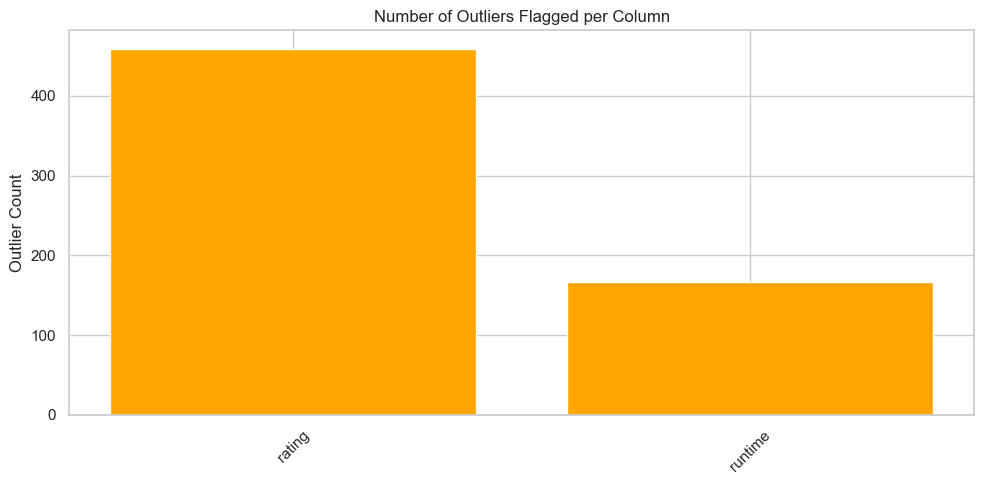


Final dataset shape: (9568, 13)
Cleaned dataset saved as 'cleaned_dataset.csv'


In [15]:
# Data Cleaning Tool
# As of right now, this tool takes care of duplicate values, NA value imputation (skewness-based) and detecting/flagging outliers.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid") # for aesthetics

# ----------------------------
# LOAD DATA
# ----------------------------
file_path = r'C:\ved\Deakin\DStudy\Project A SIT764\5.1P-resources\movie\movies.csv' # found an unclean dataset on kaggle for trial purposes
df = pd.read_csv(file_path)

# clean the column names so referencing works consistently
df.columns = df.columns.str.strip().str.lower()

# Drop fully empty columns [had this problem while working on a datset with "Unnamed" column]
df = df.dropna(axis=1, how='all')
df = df.loc[:, ~df.columns.str.contains('^unnamed')] 

print("Initial dataset shape:", df.shape)
print("Initial missing values:\n", df.isnull().sum())

# ----------------------------
# DUPLICATES & DATA TYPES
# ----------------------------
df = df.drop_duplicates()

for col in df.select_dtypes(include=['object']).columns:
    try:
        df[col] = pd.to_numeric(df[col].str.replace('%', '').str.strip(), errors='ignore') # try converting strings to numbers
    except:
        pass
    try:
        df[col] = pd.to_datetime(df[col], errors='ignore') # try parsing as datetime
    except:
        pass

# Clean text values (standard practice)
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip().str.lower()

# ----------------------------
# NUMERIC COLUMNS & BACKUP
# ----------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_before = df[numeric_cols].copy(deep=True)  # backup to compare before vs after

# ----------------------------
# FLAG MISSING VALUES
# ----------------------------
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[f'{col}_was_missing'] = df[col].isnull().astype(int)

# ----------------------------
# SKEW-BASED IMPUTATION (TEMP FOR KNN)
# ----------------------------
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        skew = df[col].skew()
        if -0.5 <= skew <= 0.5:
            df[col].fillna(df[col].mean(), inplace=True) # if data is not skewed/ approxiamtely following normal distribtuion, replacing NA values with mean
        else:
            df[col].fillna(df[col].median(), inplace=True) # if data is skewed, replacing NA values with median

# ----------------------------
# OUTLIER FLAGGING (IQR Method)
# ----------------------------
def flag_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).astype(int)

outlier_counts = {}

for col in numeric_cols:  
    flag_col = f'{col}_outlier_flag'
    df[flag_col] = flag_outliers(df[col])
    count = df[flag_col].sum()
    outlier_counts[col] = count
    if count > 0:
        print(f"Flagged {count} outliers in '{col}'")

# As of right now, the program is only identifying and flagging outliers and not treating them. 
# As the project is based around grocery data, there is a likely chance that outlier values represent discounted and promotional prices
# Thus I am not treating the outliers, just getting the total number and plotting a bar graph with that frequency
        
# ----------------------------
# VISUALIZATIONS
# ----------------------------

# Histograms [BEFORE AND AFTER]
for col in numeric_cols:  
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df_before[col], kde=True, color='gray')
    plt.title(f"'{col}' - Before Imputation")
    plt.subplot(1, 2, 2)
    sns.histplot(df[col], kde=True, color='green')
    plt.title(f"'{col}' - After Imputation")
    plt.tight_layout()
    plt.show()

# Boxplots
for col in numeric_cols:  
    plt.figure(figsize=(12, 3))
    sns.boxplot(x=df_before[col], color='gray')
    plt.title(f"'{col}' Boxplot")
    plt.show()

# Bar Plot of Outlier Flags
flag_sums = {k: v for k, v in outlier_counts.items() if v > 0}
if flag_sums:
    plt.figure(figsize=(10, 5))
    plt.bar(flag_sums.keys(), flag_sums.values(), color='orange')
    plt.title("Number of Outliers Flagged per Column")
    plt.ylabel("Outlier Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ----------------------------
# EXPORT CLEANED DATASET
# ----------------------------
print("\nFinal dataset shape:", df.shape)
df.to_csv('cleaned_dataset.csv', index=False)
print("Cleaned dataset saved as 'cleaned_dataset.csv'")


### Final comments
I tried finding a supermarket dataset that is unclean and raw but could not find satisfactory files. I found this raw, unclean dataset to try though it is based on movies. Moving forward, I will definitely try this program on the synthetic dataset that the project mentor has provided. However, before that I would like to refine the program and add things such as advanced NA value imputation techniques like KNN imputation as well as add conversion of column data types.
I plan to delve into researching advanced imputation techniques in the coming weeks to improve my program